In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("practice-estimated-PER")

LangSmith 추적을 시작합니다.
[프로젝트명]
practice-estimated-PER


In [3]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

class GraphState(TypedDict):
    question: Annotated[list, add_messages]
    context: Annotated[str, "Context"]
    answer: Annotated[str, "Answer"]
    messages: Annotated[list, add_messages]
    relevance: Annotated[str,"Relevance"]
    question_decomposed_1: Annotated[str, "분해된 질문 중 1번"]
    question_decomposed_2: Annotated[str, "분해된 질문 중 2번"]
    question_decomposed_3: Annotated[str, "분해된 질문 중 3번"]
    company: Annotated[str, "기업명"]
    sector: Annotated[str, "섹터명"]

In [4]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI


re_write_prompt = PromptTemplate(
    template = """
Transform the given question into specific, practical analysis questions that leverage financial statements.
	•	Break down the question into smaller components that define the data required for investment decisions.
	•	Utilize financial metrics (e.g., EPS, PER, ROE) from financial statements to construct a logical flow for investment analysis.
	•	Preserve the intent of the original question while converting it into actionable questions for financial analysis.

Output Format

	•	Present the transformed questions as a numbered list.
	•	Each question should be actionable and analyzable using financial statements.
	•	Provide only the output without additional explanation between the input and output.

Example

Input:
“What do you think will happen to SK Hynix’s stock price?”

Output:

1.	Calculate the fair PER of SK Hynix by analyzing the growth rates and PERs of companies in the semiconductor sector.
2.	Estimate next year’s EPS for SK Hynix by considering the semiconductor market conditions, macroeconomic environment, and the company’s current performance.
3.	Multiply the fair PER by the estimated EPS to determine the target stock price.


Input:
“What do you think will happen to Samsung Electronic’s stock price?”

Output:

1.	Calculate the fair PER of Samsung Electronic by analyzing the growth rates and PERs of companies in the semiconductor sector.
2.	Estimate next year’s EPS for Samsung Electronic by considering the semiconductor market conditions, macroeconomic environment, and the company’s current performance.
3.	Multiply the fair PER by the estimated EPS to determine the target stock price.


# Notes

- Ensure the improved question is concise and contextually relevant.
- Avoid altering the fundamental intent or meaning of the original question.


[REMEMBER] Re-written question should be in the same language as the original question.

# Here is the original question that needs to be rewritten:
{question}
""",
input_variables=["question"],
)

question_rewriter=(
    re_write_prompt | ChatOpenAI(model="gpt-4o-mini", temperature=0) | StrOutputParser()    
)

In [ ]:
# 질문 재작성
question = "SK하이닉스의 주가가 어떻게 될거 같아?"

question_rewriter.invoke({"question": question})

In [ ]:
# 질문 재작성
question = "삼성전자의 주가가 어떻게 될거 같아?"

question_rewriter.invoke({"question": question})

In [ ]:
# 질문 재작성
question = "DB하이텍의 주가가 어떻게 될거 같아?"

question_rewriter.invoke({"question": question})

In [5]:
# Query Rewrite 노드
def query_rewrite(state: GraphState) -> GraphState:
    latest_question = state["question"][-1].content
    question_rewritten = question_rewriter.invoke({"question": latest_question})
    return GraphState(question=question_rewritten)

In [6]:
def query_decomposer(state: GraphState) -> GraphState:
    question = state["question"][-1].content
    question_1 = question.split('\n')[0]
    question_2 = question.split('\n')[1]
    question_3 = question.split('\n')[2]
    return GraphState(question_decomposed_1=question_1, question_decomposed_2=question_2, question_decomposed_3=question_3)

In [ ]:
test_state = GraphState(question=['1. SK하이닉스의 공정 PER을 계산하기 위해 반도체 산업 내 기업들의 성장률과 PER을 분석할 수 있는가?\n2. SK하이닉스의 내년 EPS를 추정하기 위해 반도체 시장 상황, 거시경제 환경, 그리고 회사의 현재 성과를 고려할 수 있는가?\n3. 공정 PER에 내년 EPS를 곱하여 SK하이닉스의 목표 주가를 산출할 수 있는가?'
])

query_decomposer(test_state)

In [7]:
find_sector_and_company_prompt = PromptTemplate(
    template = """
역할:
당신은 베테랑 프롬프트 엔지니어로, 대형 언어 모델(LLM)이 최상의 성능을 발휘할 수 있도록 프롬프트를 최적화하는 데 능숙합니다.

작업:
주어진 질문에서 언급된 회사명과 섹터를 각각 추출하여 다음 형식으로 출력하십시오.

출력 형식:
	•	회사명,섹터 형태로 응답하십시오.
	•	회사명과 섹터 이외의 정보는 포함하지 마십시오.
	•	따옴표(””)는 반드시 포함하지 말고 출력하십시오.

예시:

입력:

"1. DB하이텍의 공정 PER을 계산하기 위해 반도체 산업 내 유사 기업들의 성장률과 PER을 분석하라."

출력:

DB하이텍,반도체

입력:

"1. 삼성전자의 PER을 계산하기 위해 반도체 산업 내 다른 기업들의 성장률과 PER을 분석하라."

출력:

삼성전자,반도체

추가 예시:

입력:

"1. 현대자동차의 시장 점유율을 평가하기 위해 자동차 산업 내 경쟁사의 판매 데이터를 분석하라."

출력:

현대자동차,자동차

입력:

"1. 네이버의 사용자 증가율을 측정하기 위해 IT 섹터 내 다른 플랫폼의 성장률과 사용자 수를 비교하라."

출력:

네이버,IT


# 다음 질문에 대해서 회사명과 섹터를 각각 추출하시오.
{question_decomposed_1}
""",
input_variables=["question_decomposed_1"],
)

finder_sector_and_company=(
    find_sector_and_company_prompt | ChatOpenAI(model="gpt-4o-mini", temperature=0) | StrOutputParser()    
)

In [8]:
finder_sector_and_company.invoke({"question_decomposed_1":"1.\tSK하이닉스의 공정 PER을 계산하기 위해 반도체 산업 내 다른 기업들의 성장률과 PER을 분석할 수 있는가?"})

'SK하이닉스,반도체'

In [9]:
def find_sector_and_company(state:GraphState)->GraphState:
    question_decomposed_1=state["question_decomposed_1"]
    sector_and_company = finder_sector_and_company.invoke({"question_decomposed_1":question_decomposed_1})
    company, sector = sector_and_company.split(",")
    return GraphState(company=company, sector=sector)

In [10]:
import yfinance as yf
from yahooquery import search
from deep_translator import GoogleTranslator
import pandas as pd

semiconductor_tickers = [
    'INTC',    # Intel Corporation
    'NVDA',    # NVIDIA Corporation
    'AMD',     # Advanced Micro Devices, Inc.
    'TXN',     # Texas Instruments Incorporated
    'AVGO',    # Broadcom Inc.
    'QCOM',    # Qualcomm Incorporated
    'ASML',    # ASML Holding N.V.
    'MU',      # Micron Technology, Inc.
    'LRCX',    # Lam Research Corporation
    'TSM',     # Taiwan Semiconductor Manufacturing Company Limited
    '005930.KS' # 삼성전자
]

# 사전 매핑 (특정 기업의 경우 수동 매핑)
manual_mapping = {
    "삼성전자": "005930.KS",
    # 추가적인 기업 매핑이 필요하다면 여기에 추가
}

def get_ticker(company_name):
    try:
        # 사전 매핑 확인
        # if company_name in manual_mapping:
        #     return manual_mapping[company_name]
        
        # 회사명을 영어로 번역
        translated = GoogleTranslator(source='auto', target='en').translate(company_name)
        print(f"Translated company name: {translated}")
        
        # 번역된 이름으로 검색
        results = search(translated)
        if results is not None and 'quotes' in results and len(results['quotes']) > 0:
            # 첫 번째 결과의 티커 반환
            return results['quotes'][0]['symbol']
        else:
            print(f"No ticker found for {company_name} after translation.")
            return None
    except Exception as e:
        print(f"Error translating or searching for {company_name}: {e}")
        return None


def estimate_PER(state:GraphState)->GraphState:
    target_company_ori = state["company"]
    sector = state.get('sector', "")
    
    if sector == "반도체":
        tickers = semiconductor_tickers
    else:
        print(f"지원되지 않는 섹터: {sector}")
        return
    
    # PER 및 성장률 데이터를 저장할 리스트 생성
    per_list = []
    growth_list = []
    
    for ticker in tickers:
        try:
            company = yf.Ticker(ticker)
            info = company.info
            
            # Trailing PER 가져오기
            trailing_pe = info.get('trailingPE', None)
            
            # 매출 성장률 계산 (최근 2년 간 매출 비교)
            financials = company.financials
            if 'Total Revenue' in financials.index:
                revenue = financials.loc['Total Revenue']
                revenue_sorted = revenue.sort_index(ascending=True)
                if len(revenue_sorted) >= 2:
                    growth_rate = (revenue_sorted.iloc[-1] - revenue_sorted.iloc[-2]) / revenue_sorted.iloc[-2] * 100
                else:
                    growth_rate = None
            else:
                growth_rate = None
            
            # 리스트에 추가
            per_list.append({'Ticker': ticker, 'TrailingPE': trailing_pe})
            growth_list.append({'Ticker': ticker, 'RevenueGrowth': growth_rate})
        
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
    
    # 리스트를 DataFrame으로 변환
    per_data = pd.DataFrame(per_list)
    growth_data = pd.DataFrame(growth_list)
    
    # 유효한 PER과 성장률 데이터 필터링
    valid_per = per_data['TrailingPE'].dropna()
    valid_growth = growth_data['RevenueGrowth'].dropna()
    
    # 섹터 평균 PER과 평균 매출 성장률 계산
    sector_average_per = valid_per.mean()
    sector_average_growth = valid_growth.mean()
    
    print(f"반도체 섹터 평균 PER: {sector_average_per:.2f}")
    print(f"반도체 섹터 평균 매출 성장률: {sector_average_growth:.2f}%")
    
    # 특정 기업의 PER 추정
    # 삼성전자는 이미 티커 리스트에 포함되어 있으므로 직접 사용
    target_ticker = get_ticker(target_company_ori)  # 삼성전자의 티커
    
    try:
        target_company = yf.Ticker(target_ticker)
        target_info = target_company.info
        target_pe = target_info.get('trailingPE', None)
        
        # 매출 성장률 계산
        if 'Total Revenue' in target_company.financials.index:
            target_financials = target_company.financials
            target_revenue = target_financials.loc['Total Revenue']
            target_revenue_sorted = target_revenue.sort_index(ascending=True)
            if len(target_revenue_sorted) >= 2:
                target_growth = (target_revenue_sorted.iloc[-1] - target_revenue_sorted.iloc[-2]) / target_revenue_sorted.iloc[-2] * 100
            else:
                target_growth = None
        else:
            target_growth = None
        
        print(f"{target_ticker}의 매출 성장률: {target_growth:.2f}%")
        
        if target_growth is not None and sector_average_growth != 0:
            # PER 추정
            estimated_per = sector_average_per * (target_growth / sector_average_growth)
            print(f"{target_ticker}의 추정 PER: {estimated_per:.2f}")
        else:
            print(f"{target_ticker}의 PER을 추정할 수 없습니다.")
        return GraphState(answer=estimated_per)        
    except Exception as e:
        print(f"Error fetching data for {target_ticker}: {e}")

In [ ]:
test_state = GraphState(company="삼성전자",sector="반도체")
estimate_PER(test_state)

In [11]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

In [12]:
workflow = StateGraph(GraphState)

In [13]:
workflow.add_node("query_rewrite", query_rewrite)
workflow.add_node("query_decomposer", query_decomposer)
workflow.add_node("find_sector_and_company", find_sector_and_company)
workflow.add_node("estimate_PER",estimate_PER)

In [14]:
workflow.add_edge("query_rewrite", "query_decomposer")
workflow.add_edge("query_decomposer", "find_sector_and_company")
workflow.add_edge("find_sector_and_company","estimate_PER")
workflow.add_edge("estimate_PER",END)

In [15]:
workflow.set_entry_point("query_rewrite")
memory = MemorySaver()
# 그래프 컴파일
app = workflow.compile(checkpointer=memory)

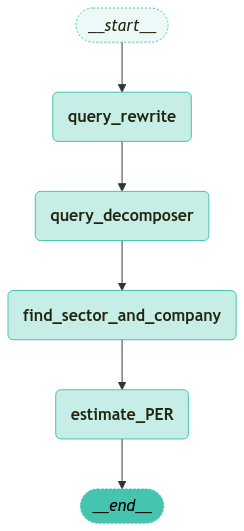

In [16]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

In [17]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = GraphState(question="SK하이닉스의 주가가 어떻게 될것 같아?")

# 그래프 실행
stream_graph(app, inputs, config, ["query_rewrite", "estimate_PER"])


🔄 Node: query_rewrite 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
1. SK하이닉스의 공정 PER을 계산하기 위해 반도체 산업 내 기업들의 성장률과 PER을 분석할 수 있는가?
2. SK하이닉스의 내년 EPS를 추정하기 위해 반도체 시장 상황, 거시경제 환경, 그리고 회사의 현재 성과를 고려할 수 있는가?
3. 공정 PER에 내년 EPS를 곱하여 SK하이닉스의 목표 주가를 산출할 수 있는가?반도체 섹터 평균 PER: 66.04
반도체 섹터 평균 매출 성장률: 15.50%
Translated company name: SK Hynix
000660.KS의 매출 성장률: -38.06%
000660.KS의 추정 PER: -162.13


In [47]:
outputs = app.get_state(config).values

In [ ]:
outputs["question_decomposed_1"]